In [1]:
from pathlib import Path
import os 

import geopandas as gpd


### Read the GeoJSON file and extract the target polygon

- Here we used Path class from Pathlib to be OS-agnostic

In [2]:
test_filename = 'test.geojson'
data_path = Path(os.getcwd()).parent / 'data'
figure_path = Path(os.getcwd()).parent / 'figures'

test_filepath = data_path / test_filename

# Read the GeoJSON file
target_gdf = gpd.read_file(test_filepath)
target_gdf

,geometry
0,"POLYGON ((5.33593 43.50158, 5.34942 43.48609, ..."


### Examining the coordinate system in use

- This will be essential in the following phases

In [3]:
target_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### Defining a method to define the sample points positions from a polygon

In [4]:
from shapely.geometry import Point
from pyproj import CRS

def polygon_binning_to_points(gdf: gpd.GeoDataFrame, resolution_m: int) -> gpd.GeoDataFrame:
    '''
    Convert a GeoDataFrame with a target polygon into a GeoDataFrame of grid points within the polygon.

    Parameters:
        gdf (gpd.GeoDataFrame): GeoDataFrame with the target polygon.
        resolution_m (int): Desired resolution in meters for the grid points.

    Returns:
        gpd.GeoDataFrame: GeoDataFrame containing the grid points within the polygon.

    NB: Assumes that the target polygon is using WGS 84 (EPSG:4326) and that the GeoDataFrame contains only one polygon.
    '''
    target_polygon = gdf.geometry[0]  # Assuming there's only one polygon in the file

    # Create a GeoDataFrame with the target polygon
    gdf_target = gpd.GeoDataFrame(geometry=[target_polygon], crs=gdf.crs)

    # Reproject the GeoDataFrame to the desired CRS (Web Mercator)
    # We need coordinates in meters to increment the binning by the desired resolution (in the test 250m)
    gdf_target_3857 = gdf_target.to_crs(CRS.from_epsg(3857))

    # Determine the bounding box of the projected polygon
    minx, miny, maxx, maxy = gdf_target_3857.geometry.bounds.values[0]

    # Generate grid points within the bounding box
    grid_points = []
    x = minx
    while x < maxx:
        y = miny
        while y < maxy:
            point = Point(x, y)
            if gdf_target_3857.geometry[0].contains(point):
                grid_points.append(point)
            y += resolution_m
        x += resolution_m

    grid_geopd = gpd.GeoDataFrame(geometry=grid_points, crs= CRS.from_epsg(3857))
    # Retransform coordinates as latitude and longitude
    grid_geopd = grid_geopd.to_crs(crs = CRS.from_epsg(4326))

    return grid_geopd

### Extract an over-sampled GeoSeries of points out of the original GeoDataFrame coordinates

In [5]:
grid_geopd = polygon_binning_to_points(gdf = target_gdf, resolution_m = 250)
grid_geopd

,geometry
0,POINT (5.33817 43.49912)
1,POINT (5.33817 43.50075)
2,POINT (5.33817 43.50238)
3,POINT (5.34042 43.49750)
4,POINT (5.34042 43.49912)
...,...
159,POINT (5.37186 43.50401)
160,POINT (5.37411 43.49912)
161,POINT (5.37411 43.50075)
162,POINT (5.37411 43.50238)


### Defining the main functions to extract all data from a GeoSeries of Shapely points

In [6]:
import requests

def get_all_soilgrid_for_points(points: gpd.GeoSeries):
    """
    Retrieve soilgrid data for multiple points using the ISQAPER API.

    Parameters:
        points (gpd.GeoSeries): GeoSeries with Shapely Point objects representing the grid points.

    Returns:
        list: List of API responses containing soilgrid data for each point.

    Assumes that each value in the GeoSeries is a Shapely Point.

    The function queries the ISRIC API and retrieves soilgrid data for each point. It returns a list
    containing the API responses for each point.
    """
    # URL and endpoint for the API
    url = 'https://isqaper.isric.org/isqaper-rest/api/1.0/query'

    # Create an empty list to store the API responses
    api_responses = []

    # Iterate over each grid point and query the API
    for point in points.geometry:
        lon, lat = point.x, point.y  # Extract the longitude and latitude from the grid point
        params = {'lon': lon, 'lat': lat}  # API parameters for the coordinates

        # Send GET request to the API
        response = requests.get(url, params=params)

        if response.status_code == 200:
            # Successful response
            data = response.json()
            api_responses.append(data)
        else:
            # Handle error response
            print(f"Error: {response.status_code}")

    return api_responses

### Getting the raw api responses

In [7]:
api_responses = get_all_soilgrid_for_points(points = grid_geopd)

### Formatting raw API responses
- (documentation in docstrings)

In [8]:
def format_soilgrid_response(api_responses):
    """
    Format soilgrid API responses.

    Parameters:
        api_responses (list): List of API responses containing soilgrid data.

    Returns:
        gpd.GeoDataFrame: GeoDataFrame with formatted soilgrid data.

    The function formats the soilgrid API responses by extracting relevant data and structuring it into
    a GeoDataFrame. The nested structure of the responses is browsed to extract short descriptions and
    values. If a metadata field is found, the values are stored in a column named after the short description.
    Otherwise, the function traverses the nested structure and extracts the short descriptions and values.

    Note: Some fields, such as Depth to Bedrock and Phosphorus using the Olsen method, are categorical
    and may require additional processing to be usable.

    The function returns a GeoDataFrame with the formatted soilgrid data.
    """
    coordinates = [[feat['geometry']['coordinates'] for feat in api_response['features']] for api_response in api_responses]
    # Create a list of Shapely Point geometries from the coordinates
    geometries = [Point(coord) for coord in coordinates]
    # Create the GeoDataFrame with points coordinates only
    gdf = gpd.GeoDataFrame(geometry=geometries, crs= CRS.from_epsg(4326))

    # browse the nested structure of api response dictionary and retrieve short description and values
    # and then fill the geodataframe column by column for all responses
    for feat_key , feat_value in api_responses[0]['features'][0]['properties']['properties'].items():
        # if there is metadata field on the current level, proceed to short description (for col names) and values extraction
        if 'metadata' in feat_value.keys():
            gdf[feat_value['metadata']['short_description']] = [api_response['features'][0]['properties']['properties'][feat_key]['value'] for api_response in api_responses]
        
        else:
            for nested_key , nested_value in feat_value.items():
                gdf[nested_value['metadata']['short_description']] = [api_response['features'][0]['properties']['properties'][feat_key][nested_key]['value'] for api_response in api_responses]

    return gdf

### Using the previous function and display head and tail of the GeoDataFrame

In [9]:
soilgrid_gdf = format_soilgrid_response(api_responses)
soilgrid_gdf

,geometry,Soil water capacity (pF=2.0),Soil water capacity (pF=2.3),Soil water capacity (pF=2.5),Permanent wilting point (PWP),Depth to bedrock,Bulk density (fine earth),Cation exchange capacity,Clay,Coarse fragments (volume),...,Soil pH,Plant-available water storage capacity,Silt,Sand,Electrical conductivity,Exchangeable potassium,Phosphorus using the Olsen method,Total nitrogen in soil,Estimated soil microbial abundance,Macrofauna groups
0,POINT (5.33817 43.49912),13.0,10.0,9.0,22.0,>200,1463.0,20.0,27.0,16.0,...,7.2,39.0,36.0,35.0,0.2,0.53,3.82,0.73,78.0,4.0
1,POINT (5.33817 43.50075),13.0,10.0,9.0,21.0,>200,1460.0,20.0,27.0,16.0,...,7.2,39.0,36.0,35.0,0.2,0.53,3.82,0.73,78.0,3.0
2,POINT (5.33817 43.50238),13.0,10.0,9.0,22.0,>200,1461.0,19.0,27.0,15.0,...,7.3,39.0,37.0,35.0,0.2,0.53,3.82,0.73,78.0,3.0
3,POINT (5.34042 43.49750),13.0,10.0,9.0,23.0,>200,1469.0,20.0,28.0,16.0,...,7.3,39.0,37.0,34.0,0.2,0.53,3.82,0.73,78.0,4.0
4,POINT (5.34042 43.49912),13.0,10.0,9.0,23.0,>200,1469.0,20.0,28.0,16.0,...,7.3,39.0,37.0,34.0,0.2,0.53,3.82,0.73,78.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,POINT (5.37186 43.50401),13.0,11.0,9.0,21.0,>200,1512.0,17.0,25.0,11.0,...,7.6,39.0,41.0,33.0,0.2,0.49,NaN,1.21,78.0,3.0
160,POINT (5.37411 43.49912),13.0,11.0,9.0,22.0,>200,1512.0,17.0,25.0,11.0,...,7.8,39.0,42.0,31.0,0.2,0.53,NaN,0.73,78.0,4.0
161,POINT (5.37411 43.50075),13.0,11.0,9.0,22.0,>200,1511.0,17.0,25.0,12.0,...,7.7,39.0,41.0,32.0,0.2,0.53,NaN,0.73,78.0,3.0
162,POINT (5.37411 43.50238),14.0,11.0,9.0,21.0,>200,1508.0,17.0,25.0,11.0,...,7.7,42.0,41.0,33.0,0.2,0.53,NaN,0.73,78.0,3.0


### We will first examine what are the available columns:

In [10]:
soilgrid_gdf.columns

Index(['geometry', 'Soil water capacity (pF=2.0)',
       'Soil water capacity (pF=2.3)', 'Soil water capacity (pF=2.5)',
       'Permanent wilting point (PWP)', 'Depth to bedrock',
       'Bulk density (fine earth)', 'Cation exchange capacity', 'Clay',
       'Coarse fragments (volume)', 'Soil organic carbon', 'Soil pH',
       'Plant-available water storage capacity', 'Silt', 'Sand',
       'Electrical conductivity', 'Exchangeable potassium',
       'Phosphorus using the Olsen method', 'Total nitrogen in soil',
       'Estimated soil microbial abundance', 'Macrofauna groups'],
      dtype='object')

### Saving intermediate GeoDataFrame to geojson

- As the test polygon was given in geojson format, we assumed that it was the more appropriate to store final values.
- Again, Pathlib was used to make the saving OS-agnostic

In [11]:
soilgrid_filename = 'soilgrid_aix.geojson'

soilgrid_gdf.to_file(data_path / soilgrid_filename, driver='GeoJSON')  

### Reformatting the GeoDataFrame

Task:  

Create a Pandas dataframe on the results that includes the following columns:  

a. sample id  
b. Lat & lng  
c. Soil ph  
d. Soil Organic Carbon Stock  
e. Soil Water Capacity  
f. Sand, Clay, Silt content  


In [12]:
selected_cols = [
    'geometry',
    'Soil pH',
    'Soil organic carbon',
    'Soil water capacity (pF=2.0)', 
    'Sand',
    'Clay',
    'Silt'
    ]

soilgrid_gdf_formatted = soilgrid_gdf[selected_cols]

# Attributing the name sample ID to the index
soilgrid_gdf_formatted.index.rename('sample ID', inplace=True)
soilgrid_gdf_formatted

soilgrid_formatted_filename = 'soilgrid_aix_formatted.geojson'

soilgrid_gdf_formatted.to_file(data_path / soilgrid_formatted_filename, driver='GeoJSON') 


### Preliminary examination of soil content for categorization

We will first take a look at the distribution of soil content

In [13]:
soil_cat_cols = ['Clay', 'Sand', 'Silt']

soilgrid_gdf_formatted[soil_cat_cols].describe()

,Clay,Sand,Silt
count,164.000000,164.000000,164.000000
mean,27.097561,30.987805,40.396341
std,1.278513,1.943963,2.146816
min,25.000000,26.000000,36.000000
25%,26.000000,30.000000,39.000000
50%,27.000000,31.500000,41.000000
75%,28.000000,32.000000,42.000000
max,30.000000,35.000000,44.000000


### As expected by the limited surface covered, we have little variability in soil composition 

- Clay between 25 and 30
- Sand between 26 and 35
- Silt between 36 and 44

We see that most of the category defined in the linked texture triangle are not applicable to our terrain, but as expressed we will do a mock categorization which very roughly approximate the diagram in https://en.wikipedia.org/wiki/Soil_texture#/media/File:SoilTextureTriangle.svg

### Categorization

Based on the graphic provided we can define roughly similar categories

We choose numpy.select function as the condition list and the choice list provide a very readable code that is easily modifiable by an non-coding expert

In [14]:
import numpy as np

gdf = soilgrid_gdf_formatted.copy()

conditions = [
    (gdf['Clay'].values > 55) & (gdf['Sand'].values < 45) & (gdf['Silt'].values < 40),
    (gdf['Clay'].values < 55) & (gdf['Clay'].values > 20) & (gdf['Sand'].values > 45) & (gdf['Silt'].values < 30),
    (gdf['Clay'].values < 20) & (gdf['Sand'].values > 45) & (gdf['Silt'].values < 30),
    (gdf['Silt'].values > 60),
    (gdf['Silt'].values >= 40) & (gdf['Silt'].values < 60),
    (gdf['Silt'].values < 40) & (gdf['Silt'].values > 30) & (gdf['Sand'].values < 45) & (gdf['Clay'].values < 65)
    # (gdf['Silt'].values > 40) & (gdf['Silt'].values > 30) & (gdf['Sand'].values < 45) & (gdf['Clay'].values < 65)

]

soil_categories = [
    'Clay',
    'Sandy Clay',
    'Sand',
    'Silt',
    'Silty Clay',
    'Clay Loam'
]

assert len(conditions) == len(soil_categories)


gdf['soil category'] = np.select(conditions, soil_categories, default='No Category')

soilgrid_formatted_filename = 'soilgrid_aix_formatted_with_category.geojson'

gdf.to_file(data_path / soilgrid_formatted_filename, driver='GeoJSON') 


,geometry,Soil pH,Soil organic carbon,Soil water capacity (pF=2.0),Sand,Clay,Silt,soil category
sample ID,,,,,,,,
0,POINT (5.33817 43.49912),7.2,2.1,13.0,35.0,27.0,36.0,Clay Loam
1,POINT (5.33817 43.50075),7.2,2.2,13.0,35.0,27.0,36.0,Clay Loam
2,POINT (5.33817 43.50238),7.3,2.1,13.0,35.0,27.0,37.0,Clay Loam
3,POINT (5.34042 43.49750),7.3,2.0,13.0,34.0,28.0,37.0,Clay Loam
4,POINT (5.34042 43.49912),7.3,2.0,13.0,34.0,28.0,37.0,Clay Loam
...,...,...,...,...,...,...,...,...
159,POINT (5.37186 43.50401),7.6,1.5,13.0,33.0,25.0,41.0,Silty Clay
160,POINT (5.37411 43.49912),7.8,1.4,13.0,31.0,25.0,42.0,Silty Clay
161,POINT (5.37411 43.50075),7.7,1.4,13.0,32.0,25.0,41.0,Silty Clay


### Plotting of samples on a map

- We choose to represent both requested examples, using size for carbon stock and hue for pH as it will provide more information and enough readability on a single visualization

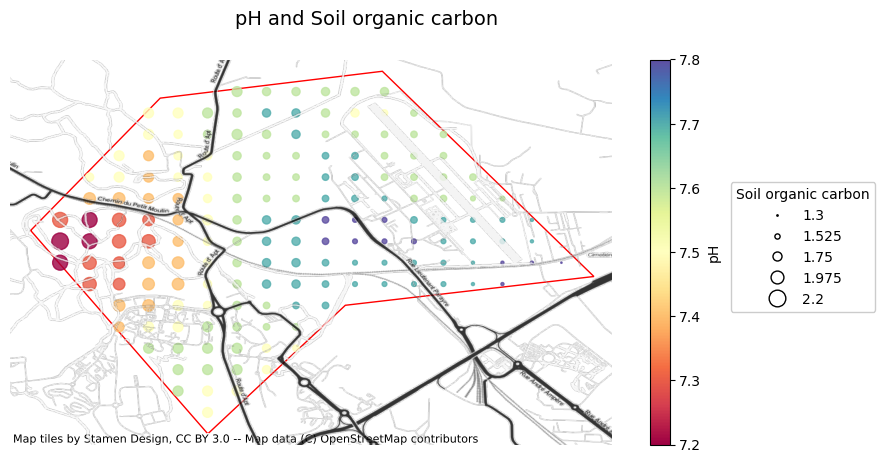

In [15]:
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.cm import ScalarMappable
from matplotlib import cm
import geoplot as gplt
import contextily as ctx

fig, ax = plt.subplots(figsize=(10,5))
fig.suptitle("pH and Soil organic carbon", size=14)

norm = colors.Normalize(vmin=soilgrid_gdf['Soil pH'].min(), vmax=soilgrid_gdf['Soil pH'].max())
# I choose spectral as I liked representing more acid values in red and more basics in blue.
cmap = cm.Spectral
# Adding colorbar at scale
fig.colorbar(ScalarMappable(norm=norm, cmap=cmap), orientation='vertical', label='pH', ax=ax)
# Representing original polygon requested in red, to stand out of the basemap
gplt.polyplot(target_gdf, ax = ax, edgecolor='red')
# Add basemap, the chosen one looked nice as it is clear and do not obfuscate colored scatter points
ctx.add_basemap(ax, crs = soilgrid_gdf.crs, source=ctx.providers.Stamen.TonerHybrid, alpha=0.8)

ax = gplt.pointplot(
    soilgrid_gdf,
    hue='Soil pH', scale='Soil organic carbon', limits=(1, 12), cmap='Spectral',
    legend=True, legend_var='scale', alpha=0.8, ax=ax, legend_kwargs={"title": "Soil organic carbon", 'framealpha': 1, 'facecolor':'white', 'bbox_to_anchor': (1.45, 0.7)}
)
# Save files in pdf format
plt.savefig(figure_path / "pH_and_Carbon_aix_points.pdf", dpi=300)

In [16]:
from scipy.interpolate import griddata
import numpy as np
import geopandas as gpd

def interpolate_point_measures(gdf: gpd.GeoDataFrame, selected_measures: list) -> gpd.GeoDataFrame:
    """
    Interpolate point measures to a regular grid.

    Parameters:
        gdf (gpd.GeoDataFrame): GeoDataFrame containing the point measures.
        selected_measures (list): List of selected measures to interpolate.

    Returns:
        gpd.GeoDataFrame: GeoDataFrame with interpolated measures on a regular grid.

    The function takes a GeoDataFrame containing point measures and interpolates the selected measures
    to a regular grid using the scipy.interpolate.griddata function. The grid is defined by the bounding
    box of the input data, and the step size can be adjusted as per the needs. The interpolation method
    used is linear.

    The function returns a GeoDataFrame with the interpolated measures on a regular grid.
    """
    xmin, ymin, xmax, ymax = gdf.total_bounds  # Get the bounding box of the data
    grid_x, grid_y = np.mgrid[xmin:xmax:500j, ymin:ymax:500j]  # Adjust the step size as per your needs

    interpolated_data = {}
    points = np.vstack([gdf.geometry.x.values, gdf.geometry.y.values]).T
    for measure in selected_measures:
        values = gdf[measure].values
        interpolated_values = griddata(points, values, (grid_x, grid_y), method='linear')
        interpolated_data[measure] = interpolated_values

    interp_gpd = gpd.GeoDataFrame()
    for col_name, values in interpolated_data.items():
        interp_gpd[col_name] = values.flatten()

    interp_gpd = interp_gpd.set_geometry(gpd.GeoSeries(map(Point, zip(grid_x.flatten(), grid_y.flatten()))))
    interp_gpd.crs = gdf.crs

    return interp_gpd


### Interpolate the original GeoDataFrame at a higher resolution for few selected columns


In [17]:
selected_measures = ['Soil organic carbon', 'Soil pH',
       'Plant-available water storage capacity', 'Clay', 'Sand', 'Silt']

interp_gpd = interpolate_point_measures(gdf = soilgrid_gdf, selected_measures = selected_measures)

### Plotting the heatmap as a scatter plot with overlapping dots to render a (faked) heatmap

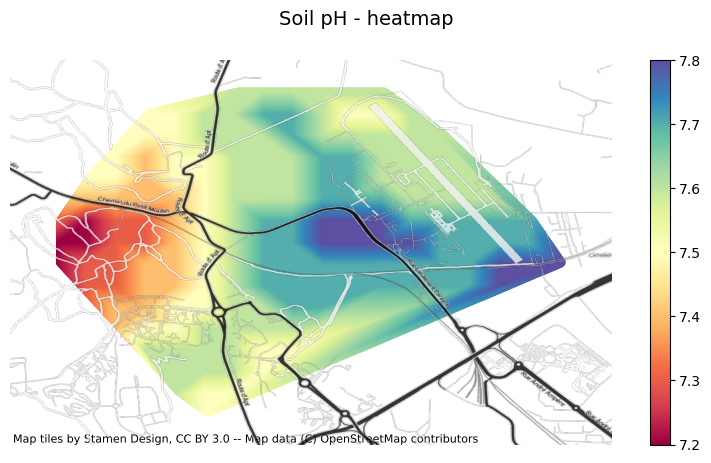

In [18]:
fig, ax = plt.subplots(figsize=(10,5))
fig.suptitle("Soil pH - heatmap", size=14)

gplt.pointplot(
    interp_gpd.dropna(), # dropna() avoid having black dots plotted outside of the originally requested polygon
    hue='Soil pH', cmap='Spectral',
    legend=True, legend_var='hue', alpha=0.8, ax=ax
)

# gplt.polyplot(target_gdf, ax = ax, edgecolor='red') # Uncomment to see original polygon bounding box

ctx.add_basemap(ax, crs = soilgrid_gdf.crs, source=ctx.providers.Stamen.TonerHybrid, alpha=0.8)

# Save files in pdf format
plt.savefig(figure_path / "pH_aix_heatmap.pdf", dpi=300)

### Extra: Soil categorization going a bit more data-driven

- We could go a bit further to see what type of soil residual explain most of the variance in soil category
- However, given the relative homogeneity in the soil composition, the following approach does not make much sense for small land or homogeneous soil composition
- The following mostly prove that unsupervised (or semi-supervised) approach based on dimensionality reductions and clustering are not relevant for this particular test, however they might be for a bigger plot of land.

### PCA examination of soil composition

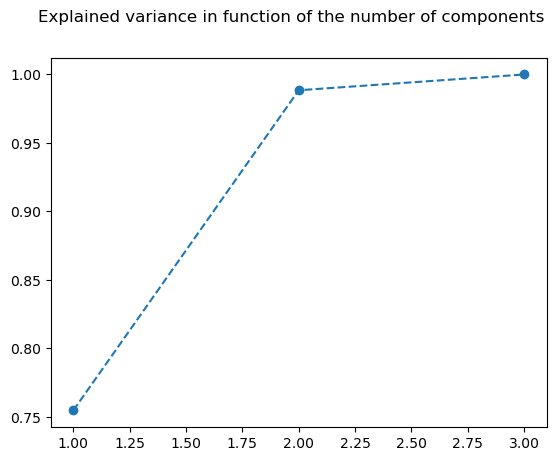

In [19]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


soil_cat_cols = ['Clay', 'Sand', 'Silt']
scaler = StandardScaler()
scaled_soil_content = scaler.fit_transform(gdf[soil_cat_cols])

pca = PCA()
pca.fit(gdf[soil_cat_cols])

plt.figure()
plt.plot(range(1,4), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.suptitle('Explained variance in function of the number of components')
pca = PCA(n_components=2)
pca.fit(gdf[soil_cat_cols])
scores_pca_soil = pca.transform(gdf[soil_cat_cols])


- We can see that most of the variance > 98% is explained with 2 components
- Let's examine what features are more important to explain the variance of the soil elements

In [20]:
pca.components_

array([[ 0.11937396,  0.64163968, -0.7576598 ],
       [ 0.79617822, -0.51778252, -0.31305193]])

Content in Silt (index 2) and then content in Clay (index 0) appears to be the most determinant factors that explain the variability of soil composition:

we can simplify soils has being:

- soils with less Silt
- and soils with more Clay

So we will focus on these divisions

Additionally we could plot the pca-transformed points of soil to see if there was any obvious clustering in the types of soil.

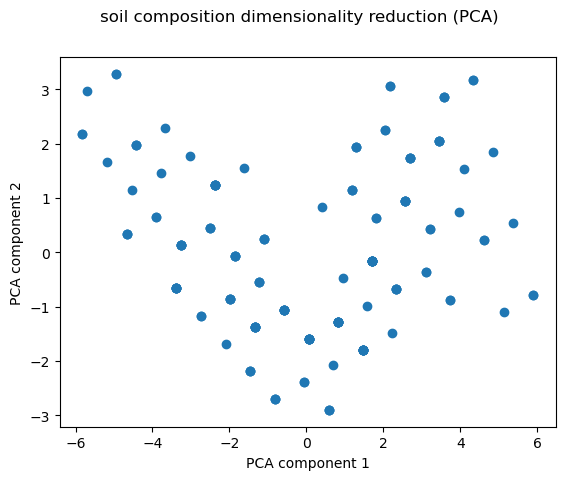

In [21]:
ax = plt.scatter(scores_pca_soil[:,0],scores_pca_soil[:,1])
ax = plt.suptitle('soil composition dimensionality reduction (PCA)')
ax = plt.xlabel('PCA component 1')
ax = plt.ylabel('PCA component 2')

As we mentioned before, it could be interesting to dig more on this approach, only if there were more datapoints on a more diverse range of soil.  
Here, any clustering would be mostly artificial or random, the distance between neighboring points being mostly similar.